---
format: 
  html:
    embed-resources: true
execute:
  echo: true
code-fold: true
title: Data is Delicious
author: James Compagno
jupyter: python3
---

In [2]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import plotnine as p9
from calendar import day_name

/Users/jamescompagno/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1. Data from unstructured websites

This website contains many weekly meal plans. Choose one that seems delicious to you. Scrape the weekly meal plan into a table with the following columns:

Day of the Week
Name of Recipe
Link to Recipe
Price of Recipe

In [3]:
#What the HTML looks like

# <div class="wp-block-group"><div class="wp-block-group__inner-container is-layout-flow wp-block-group-is-layout-flow">
# <p class="has-text-align-left"><strong>Monday</strong>: <a href="https://tastesbetterfromscratch.com/favorite-baked-salmon-with-dill/">Baked Salmon</a> $14.87</p>

# <p class="has-text-align-left"><strong>Tuesday</strong>: <a href="https://tastesbetterfromscratch.com/classic-homemade-chili/">Classic Chili</a> $21.49</p>

# <p class="has-text-align-left"><strong>Wednesday: </strong><a href="https://tastesbetterfromscratch.com/calzones/">Calzone</a> $5.63</p>

# <p class="has-text-align-left"><strong>Thursday:</strong> <a href="https://tastesbetterfromscratch.com/chickpea-curry/">Chickpea Curry</a> $14.89</p>

# <p class="has-text-align-left"><strong>Friday:</strong> <a href="https://tastesbetterfromscratch.com/mexican-pizzas/">Mexican Pizza</a> $17.51</p>
# </div></div>

In [4]:
URL = "https://tastesbetterfromscratch.com/meal-plan-169/"
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

response = requests.get(URL, headers=HEADERS, timeout=30)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

day_pattern = re.compile(r"^(\w+)\s*:", re.IGNORECASE)
price_pattern = re.compile(r"\$\d+(?:\.\d{2})?")
rows = []

for element in soup.find_all(["p", "li"]):
    text = " ".join(element.get_text(" ", strip=True).split())

    day_match = day_pattern.search(text)
    if not day_match:
        continue
    day = day_match.group(1).title()

    a = element.find("a")
    if not a:
        continue

    recipe_name = a.get_text(strip=True)
    recipe_url = a.get("href") or None

    price_match = price_pattern.search(text)
    price = price_match.group(0) if price_match else None

    rows.append({
        "Day of the Week": day,
        "Name of Recipe": recipe_name,
        "Link to Recipe": recipe_url,
        "Price of Recipe": price
    })

# Sort rows by weekday order and create DataFrame
day_names = list(day_name)  # ['Monday', 'Tuesday', ...]
order = {d: i for i, d in enumerate(day_names)}
rows = sorted(rows, key=lambda r: order.get(r["Day of the Week"], 99))

df_plan = pd.DataFrame(rows, columns=["Day of the Week", "Name of Recipe", "Link to Recipe", "Price of Recipe"])
df_plan


,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Baked Salmon,https://tastesbetterfromscratch.com/favorite-b...,$14.87
1,Tuesday,Classic Chili,https://tastesbetterfromscratch.com/classic-ho...,$21.49
2,Wednesday,Calzone,https://tastesbetterfromscratch.com/calzones/,$5.63
3,Thursday,Chickpea Curry,https://tastesbetterfromscratch.com/chickpea-c...,$14.89
4,Friday,Mexican Pizza,https://tastesbetterfromscratch.com/mexican-pi...,$17.51


# 2. Data from an API

Using the Tasty API from the practice activity, search for recipes that match the “Monday” recipe in your meal plan. Compile a table of all these recipes.

In [5]:
# url = "https://tasty.p.rapidapi.com/recipes/list"

# querystring = {"from":"0","size":"20","q":"daikon"}

# headers = {
#     "X-RapidAPI-Key": "8e7b4eb66emsh05b4af84d6f86e3p163d2ejsn7e5cbfcbda11",
#     "X-RapidAPI-Host": "tasty.p.rapidapi.com"
# }

# response = requests.get(url, headers=headers, params=querystring)

# print(response.json())

In [6]:
# API
api_key = "8e7b4eb66emsh05b4af84d6f86e3p163d2ejsn7e5cbfcbda11"

def fetch_recipes(search_term, result_limit=100):
    urltasty = "https://tasty.p.rapidapi.com/recipes/list"
    request_headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "tasty.p.rapidapi.com"}

    params = {"from": "0", "size": str(min(result_limit, 100)), "q": search_term}
    response = requests.get(urltasty, headers=request_headers, params=params, timeout=30)
    return response

def sanitize_search_query(text: str) -> str:
    """Remove special characters and normalize whitespace."""
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

# Get Monday's recipe from meal plan
monday_meals = df_plan[df_plan["Day of the Week"].str.lower() == "monday"]
if monday_meals.empty:
    print("No Monday meals found in df_plan")
    raise SystemExit
target_recipe = monday_meals.iloc[0]["Name of Recipe"]

# Prepare search queries with varying specificity
exact_query = target_recipe
sanitized_query = sanitize_search_query(target_recipe)
significant_words = [word for word in sanitized_query.split() if len(word) > 3]
broad_query = " ".join(significant_words) if significant_words else sanitized_query

query_list = [exact_query, sanitized_query]
if broad_query not in query_list:
    query_list.append(broad_query)

# Fetch and parse recipe data
recipe_data = []
for search_query in query_list:
    response = fetch_recipes(search_query, result_limit=100)
    recipe_results = response.json().get("results", [])
    
    for recipe in recipe_results:
        nutritional_info = recipe.get("nutrition") or {}
        user_ratings = recipe.get("user_ratings") or {}
        recipe_slug = recipe.get("slug")
        
        recipe_data.append({
            "QueryUsed": search_query,
            "Day of the Week": "Monday",
            "Mealplan Recipe": target_recipe,
            "Tasty Recipe Name": recipe.get("name"),
            "Tasty URL": f"https://tasty.co/recipe/{recipe_slug}" if recipe_slug else None,
            "Calories": nutritional_info.get("calories"),
            "Protein_g": nutritional_info.get("protein"),
            "Fat_g": nutritional_info.get("fat"),
            "Carbs_g": nutritional_info.get("carbohydrates"),
            "Sugar_g": nutritional_info.get("sugar"),
            "Fiber_g": nutritional_info.get("fiber"),
            "UserRatingScore": (user_ratings.get("score") if isinstance(user_ratings, dict) else None)
        })
    
    if recipe_data: 
        break

In [7]:
monday_recpies = pd.DataFrame(recipe_data)
print("Recipes for Monday")
print(monday_recpies.head(10))

Recipes for Monday
      QueryUsed Day of the Week Mealplan Recipe  \
0  Baked Salmon          Monday    Baked Salmon   
1  Baked Salmon          Monday    Baked Salmon   
2  Baked Salmon          Monday    Baked Salmon   
3  Baked Salmon          Monday    Baked Salmon   
4  Baked Salmon          Monday    Baked Salmon   
5  Baked Salmon          Monday    Baked Salmon   
6  Baked Salmon          Monday    Baked Salmon   
7  Baked Salmon          Monday    Baked Salmon   
8  Baked Salmon          Monday    Baked Salmon   
9  Baked Salmon          Monday    Baked Salmon   

                        Tasty Recipe Name  \
0  Puff Pastry Salmon (Salmon Wellington)   
1                 Honey Soy-Glazed Salmon   
2              One-Pan Salmon And Veggies   
3     One-Pan Lemon Herb Salmon & Veggies   
4                     Avocado Lime Salmon   
5                     Maple-Glazed Salmon   
6                 Parmesan Crusted Salmon   
7          Parchment Garlic Butter Salmon   
8             

# 3. Automate it

Write a function called get_mealplan_data that performs 2 and 3 above automatically. That is, your function should:

Take as input a number 100-210, representing which weekly meal plan you are referencing.

Scrape the meal plan from the meal planning site.

Query the Tasty API for recipes matching each of the ones in the chosen weekly meal plan.

Output a single dataset, which contains all the information from the above

Hint: You may have an easier time if you write two smaller functions, get_weekly_plan and match_recipe, and then you use them inside your main function.

Run the following code, which should work if your function is complete:

df = get_mealplan_data(202)

In [8]:
def get_weekly_plan(plan_number):
    HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    URL = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"

    resp = requests.get(URL, headers=HEADERS, timeout=30)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    # Accept "Monday:", "Monday -", "Monday —", etc.
    day_pattern = re.compile(
        r"^(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b[\s:\-–—]*",
        re.IGNORECASE
    )
    price_pattern = re.compile(r"\$\d+(?:\.\d{2})?")
    rows = []

    container = soup.select_one(".entry-content") or soup
    current_day = None

    for el in container.find_all(["p", "li"]):
        text = " ".join(el.get_text(" ", strip=True).split())
        if not text:
            continue

        m = day_pattern.match(text)
        if m:
            # New day label found
            current_day = m.group(1).title()
            remainder = text[m.end():].strip(" :–—-")
            a = el.find("a")

            recipe_name = a.get_text(strip=True) if a else (remainder if remainder else None)
            recipe_url = (a.get("href") if a else None) or None
            price_match = price_pattern.search(text)
            price = price_match.group(0) if price_match else None

            # If anything useful is present inline, record now
            if recipe_name or recipe_url or price:
                rows.append({
                    "Day of the Week": current_day,
                    "Name of Recipe": recipe_name,
                    "Link to Recipe": recipe_url,
                    "Price of Recipe": price
                })
                current_day = None  # assume one recipe per day
            continue

        # If the link is on the following element after a day label
        if current_day:
            a = el.find("a")
            if a:
                recipe_name = a.get_text(strip=True)
                recipe_url = a.get("href") or None
                price_match = price_pattern.search(text)
                price = price_match.group(0) if price_match else None

                rows.append({
                    "Day of the Week": current_day,
                    "Name of Recipe": recipe_name,
                    "Link to Recipe": recipe_url,
                    "Price of Recipe": price
                })
                current_day = None

    # Sort Monday..Sunday
    from calendar import day_name
    order = {d: i for i, d in enumerate(day_name)}
    rows = sorted(rows, key=lambda r: order.get(r["Day of the Week"], 99))

    return pd.DataFrame(rows, columns=[
        "Day of the Week", "Name of Recipe", "Link to Recipe", "Price of Recipe"
    ])


In [9]:
weekly_plan = get_weekly_plan(169)
weekly_plan

,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Baked Salmon,https://tastesbetterfromscratch.com/favorite-b...,$14.87
1,Tuesday,Classic Chili,https://tastesbetterfromscratch.com/classic-ho...,$21.49
2,Wednesday,Calzone,https://tastesbetterfromscratch.com/calzones/,$5.63
3,Thursday,Chickpea Curry,https://tastesbetterfromscratch.com/chickpea-c...,$14.89
4,Friday,Mexican Pizza,https://tastesbetterfromscratch.com/mexican-pi...,$17.51


In [10]:
def match_recipe(day):
    day_meals = weekly_plan[weekly_plan["Day of the Week"].str.lower() == day.lower()]
    if day_meals.empty:
        print("No ", day, " meals found in weekly_plan")
        raise SystemExit
    target_recipe = day_meals.iloc[0]["Name of Recipe"]

    # Prepare search queries with varying specificity
    exact_query = target_recipe
    sanitized_query = sanitize_search_query(target_recipe)
    significant_words = [word for word in sanitized_query.split() if len(word) > 3]
    broad_query = " ".join(significant_words) if significant_words else sanitized_query

    # Fallback: single keyword if broad_query fails
    fallback_query = significant_words[-1] if significant_words else sanitized_query

    query_list = [exact_query, sanitized_query]
    if broad_query not in query_list:
        query_list.append(broad_query)
    if fallback_query not in query_list:
        query_list.append(fallback_query)

    recipe_data2 = []
    for search_query in query_list:
        response = fetch_recipes(search_query, result_limit=100)
        recipe_results = response.json().get("results", [])

        for recipe in recipe_results:
            nutritional_info = recipe.get("nutrition") or {}
            user_ratings = recipe.get("user_ratings") or {}
            recipe_slug = recipe.get("slug")

            recipe_data2.append({
                "QueryUsed": search_query,
                "Day of the Week": day.title(),
                "Mealplan Recipe": target_recipe,
                "Tasty Recipe Name": recipe.get("name"),
                "Tasty URL": f"https://tasty.co/recipe/{recipe_slug}" if recipe_slug else None,
                "Calories": nutritional_info.get("calories"),
                "Protein_g": nutritional_info.get("protein"),
                "Fat_g": nutritional_info.get("fat"),
                "Carbs_g": nutritional_info.get("carbohydrates"),
                "Sugar_g": nutritional_info.get("sugar"),
                "Fiber_g": nutritional_info.get("fiber"),
                "UserRatingScore": (user_ratings.get("score") if isinstance(user_ratings, dict) else None)
            })

        if recipe_data2: 
            break  

    # If still nothing found, make a final very broad query
    if not recipe_data2:
        broad_response = fetch_recipes(target_recipe.split()[0], result_limit=100)
        recipe_results = broad_response.json().get("results", [])
        for recipe in recipe_results:
            nutritional_info = recipe.get("nutrition") or {}
            user_ratings = recipe.get("user_ratings") or {}
            recipe_slug = recipe.get("slug")
            recipe_data2.append({
                "QueryUsed": f"{target_recipe.split()[0]} (fallback)",
                "Day of the Week": day.title(),
                "Mealplan Recipe": target_recipe,
                "Tasty Recipe Name": recipe.get("name"),
                "Tasty URL": f"https://tasty.co/recipe/{recipe_slug}" if recipe_slug else None,
                "Calories": nutritional_info.get("calories"),
                "Protein_g": nutritional_info.get("protein"),
                "Fat_g": nutritional_info.get("fat"),
                "Carbs_g": nutritional_info.get("carbohydrates"),
                "Sugar_g": nutritional_info.get("sugar"),
                "Fiber_g": nutritional_info.get("fiber"),
                "UserRatingScore": (user_ratings.get("score") if isinstance(user_ratings, dict) else None)
            })

    return pd.DataFrame(recipe_data2)

In [11]:
weekday_example = match_recipe("Tuesday")
weekday_example.head()

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Classic Chili,Tuesday,Classic Chili,Chili Chicken-stuffed Parathas,https://tasty.co/recipe/chili-chicken-stuffed-...,324,23,21,8,3,2,0.911348
1,Classic Chili,Tuesday,Classic Chili,Street-Style Butta (India),https://tasty.co/recipe/street-style-butta-india,183,4,8,29,6,3,0.898990
2,Classic Chili,Tuesday,Classic Chili,Carrot Dogs 4 Ways,https://tasty.co/recipe/carrot-dogs-4-ways,198,6,2,37,10,5,0.903930
3,Classic Chili,Tuesday,Classic Chili,Salmon With Pesto Veggie Noodles By Wolfgang Puck,https://tasty.co/recipe/salmon-with-pesto-vegg...,405,23,20,36,19,10,0.931507
4,Classic Chili,Tuesday,Classic Chili,Margarita Burger,https://tasty.co/recipe/margarita-burger,1084,24,29,114,43,10,1.000000


In [12]:
weekday_example.tail()

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
1,Classic Chili,Tuesday,Classic Chili,Street-Style Butta (India),https://tasty.co/recipe/street-style-butta-india,183,4,8,29,6,3,0.898990
2,Classic Chili,Tuesday,Classic Chili,Carrot Dogs 4 Ways,https://tasty.co/recipe/carrot-dogs-4-ways,198,6,2,37,10,5,0.903930
3,Classic Chili,Tuesday,Classic Chili,Salmon With Pesto Veggie Noodles By Wolfgang Puck,https://tasty.co/recipe/salmon-with-pesto-vegg...,405,23,20,36,19,10,0.931507
4,Classic Chili,Tuesday,Classic Chili,Margarita Burger,https://tasty.co/recipe/margarita-burger,1084,24,29,114,43,10,1.000000
5,Classic Chili,Tuesday,Classic Chili,Hack Your Dinner,https://tasty.co/recipe/hack-your-dinner,1231,66,53,122,19,11,0.750000


In [13]:
def get_mealplan_data(choosen_recepie_number):
    global weekly_plan
    weekly_plan = get_weekly_plan(choosen_recepie_number)

    days = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
    df_all = pd.concat([match_recipe(d) for d in days], ignore_index=True)

    # Enforce Monday -> Friday ordering
    order = {d: i for i, d in enumerate(["Monday","Tuesday","Wednesday","Thursday","Friday"])}
    df_all = df_all.sort_values(
        by="Day of the Week",
        key=lambda s: s.map(order)
    ).reset_index(drop=True)

    return df_all

In [14]:
df = get_mealplan_data(202)

In [15]:
df

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Chicken (fallback),Monday,Chicken Divan,Low-Carb Avocado Chicken Salad,https://tasty.co/recipe/low-carb-avocado-chick...,249.0,29.0,8.0,13.0,8.0,3.0,0.917450
1,Chicken (fallback),Monday,Chicken Divan,"Crispy, Creamy Chicken Cordon Bleu",https://tasty.co/recipe/crispy-creamy-chicken-...,700.0,55.0,29.0,52.0,5.0,2.0,0.953156
2,Chicken (fallback),Monday,Chicken Divan,Chicken & Veggie Stir-Fry,https://tasty.co/recipe/chicken-veggie-stir-fry,220.0,28.0,5.0,14.0,3.0,3.0,0.957846
3,Chicken (fallback),Monday,Chicken Divan,Chicken Spinach Alfredo Rotini Pasta,https://tasty.co/recipe/chicken-spinach-alfred...,NaN,NaN,NaN,NaN,NaN,NaN,0.977950
4,Chicken (fallback),Monday,Chicken Divan,One-Pan Honey Garlic Chicken,https://tasty.co/recipe/one-pan-honey-garlic-c...,407.0,49.0,12.0,23.0,18.0,3.0,0.961471
...,...,...,...,...,...,...,...,...,...,...,...,...
116,Chicken Gyros,Friday,Chicken Gyros,Greek Chicken Gyro Salad,https://tasty.co/recipe/greek-chicken-gyro-salad,785.0,77.0,14.0,87.0,42.0,6.0,0.949833
117,Chicken Gyros,Friday,Chicken Gyros,Chicken Gyros,https://tasty.co/recipe/chicken-gyros,510.0,43.0,15.0,50.0,17.0,3.0,0.955990
118,Chicken Gyros,Friday,Chicken Gyros,Tasty Dinners for Every Night of December,https://tasty.co/recipe/tasty-dinner-for-every...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,Chicken Gyros,Friday,Chicken Gyros,Street Food Recipes Around The World,https://tasty.co/recipe/street-food-recipes-ar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df = get_mealplan_data(169)
df

,QueryUsed,Day of the Week,Mealplan Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein_g,Fat_g,Carbs_g,Sugar_g,Fiber_g,UserRatingScore
0,Baked Salmon,Monday,Baked Salmon,Puff Pastry Salmon (Salmon Wellington),https://tasty.co/recipe/puff-pastry-salmon-sal...,898.0,31.0,61.0,55.0,6.0,4.0,0.967798
1,Baked Salmon,Monday,Baked Salmon,One-Pan Salmon And Rainbow Veggies,https://tasty.co/recipe/one-pan-rainbow-salmon...,387.0,30.0,17.0,29.0,19.0,5.0,0.981308
2,Baked Salmon,Monday,Baked Salmon,Cajun Blackened Salmon,https://tasty.co/recipe/cajun-blackened-salmon,496.0,28.0,31.0,28.0,16.0,8.0,0.964072
3,Baked Salmon,Monday,Baked Salmon,Parchment Lemon Dill Salmon,https://tasty.co/recipe/parchment-lemon-dill-s...,554.0,46.0,33.0,16.0,5.0,5.0,0.964486
4,Baked Salmon,Monday,Baked Salmon,Pineapple Sweet Chili Salmon,https://tasty.co/recipe/pineapple-sweet-chili-...,NaN,NaN,NaN,NaN,NaN,NaN,0.938689
...,...,...,...,...,...,...,...,...,...,...,...,...
85,Mexican Pizza,Friday,Mexican Pizza,BBQ Chicken Pizza Tacos,https://tasty.co/recipe/bbq-chicken-pizza-tacos,326.0,19.0,14.0,29.0,5.0,0.0,0.977876
86,Mexican Pizza,Friday,Mexican Pizza,Cheesy Taco Breadsticks,https://tasty.co/recipe/cheesy-taco-breadsticks,593.0,35.0,26.0,45.0,3.0,2.0,0.915594
87,Mexican Pizza,Friday,Mexican Pizza,Chiles En Vinagre,https://tasty.co/recipe/chiles-en-vinagre,14.0,0.0,0.0,3.0,1.0,0.0,0.875000
88,Mexican Pizza,Friday,Mexican Pizza,April Fools’ Day Mexican Pizza,https://tasty.co/recipe/april-fools-day-mexica...,NaN,NaN,NaN,NaN,NaN,NaN,0.700000


# 4. Add a column with fuzzy matching

Add a column to your df dataset indicating whether the recipe in that row is vegetarian or not.

You may assume, for our purposes, that all recipes containing meat will have the name of a common meat in the recipe title. (Of course, that is not universally true - but we’ll assume it is for now.)

In [17]:
def mark_vegetarian(name):
    if not isinstance(name, str) or not name.strip():
        return True  
    
    s = name.lower()

    meat_words = [
        "chicken", "beef", "pork", "bacon", "ham", "sausage", "turkey", "shrimp",
        "salmon", "tuna", "fish", "steak", "lamb", "duck", "veal", "goat",
        "pepperoni", "anchovy", "anchovies", "prosciutto", "chorizo", "crab",
        "lobster", "oyster", "clam", "scallop"
    ]

    pattern = r"\b(" + "|".join([re.escape(word) + "s?" for word in meat_words]) + r")\b"

    return not re.search(pattern, s)

df = df.copy()
df["Vegetarian"] = df["Tasty Recipe Name"].apply(mark_vegetarian)


# 6. Analyze
Make a visualization that tells a story about nutrition information (available in the Tasty API results) across the week for Mealplan 202. Your visualization should also indicate which meals are vegetarian.

In [18]:
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["Day of the Week"] = pd.Categorical(df["Day of the Week"], categories=day_order, ordered=True)

/Users/jamescompagno/Library/Python/3.9/lib/python/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 13 rows containing non-finite values.


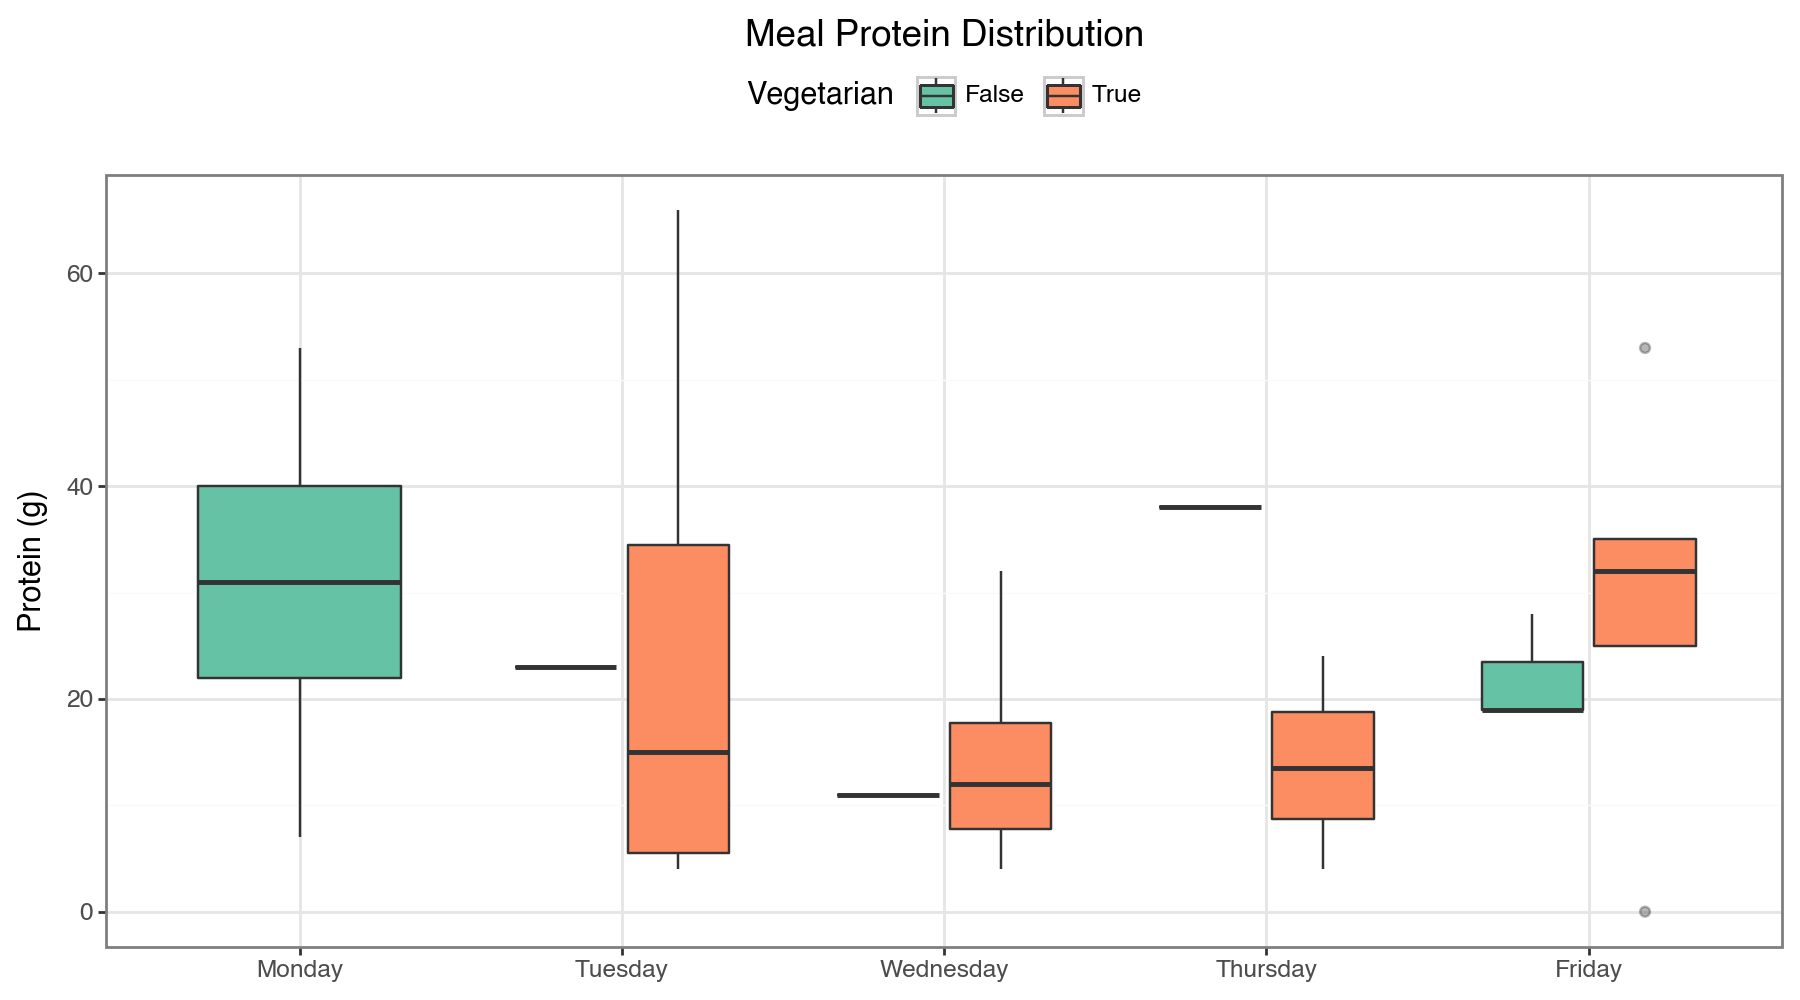

In [19]:
p = (
    p9.ggplot(df, p9.aes(x="Day of the Week", y="Protein_g", fill="Vegetarian"))
    + p9.geom_boxplot(width=0.7, outlier_alpha=0.35)
    + p9.scale_fill_brewer(type="qual", palette="Set2")
    + p9.scale_y_continuous(name="Protein (g)")
    + p9.labs(x="", title="Meal Protein Distribution", fill="Vegetarian")
    + p9.theme_bw()
    + p9.theme(figure_size=(9, 5), legend_position="top")
)

/Users/jamescompagno/Library/Python/3.9/lib/python/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 13 rows containing non-finite values.


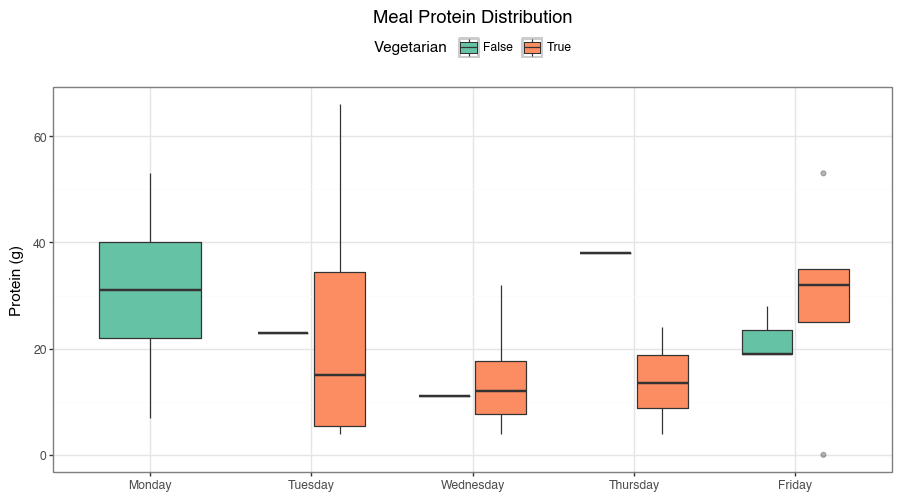

/Users/jamescompagno/Library/Python/3.9/lib/python/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 13 rows containing non-finite values.


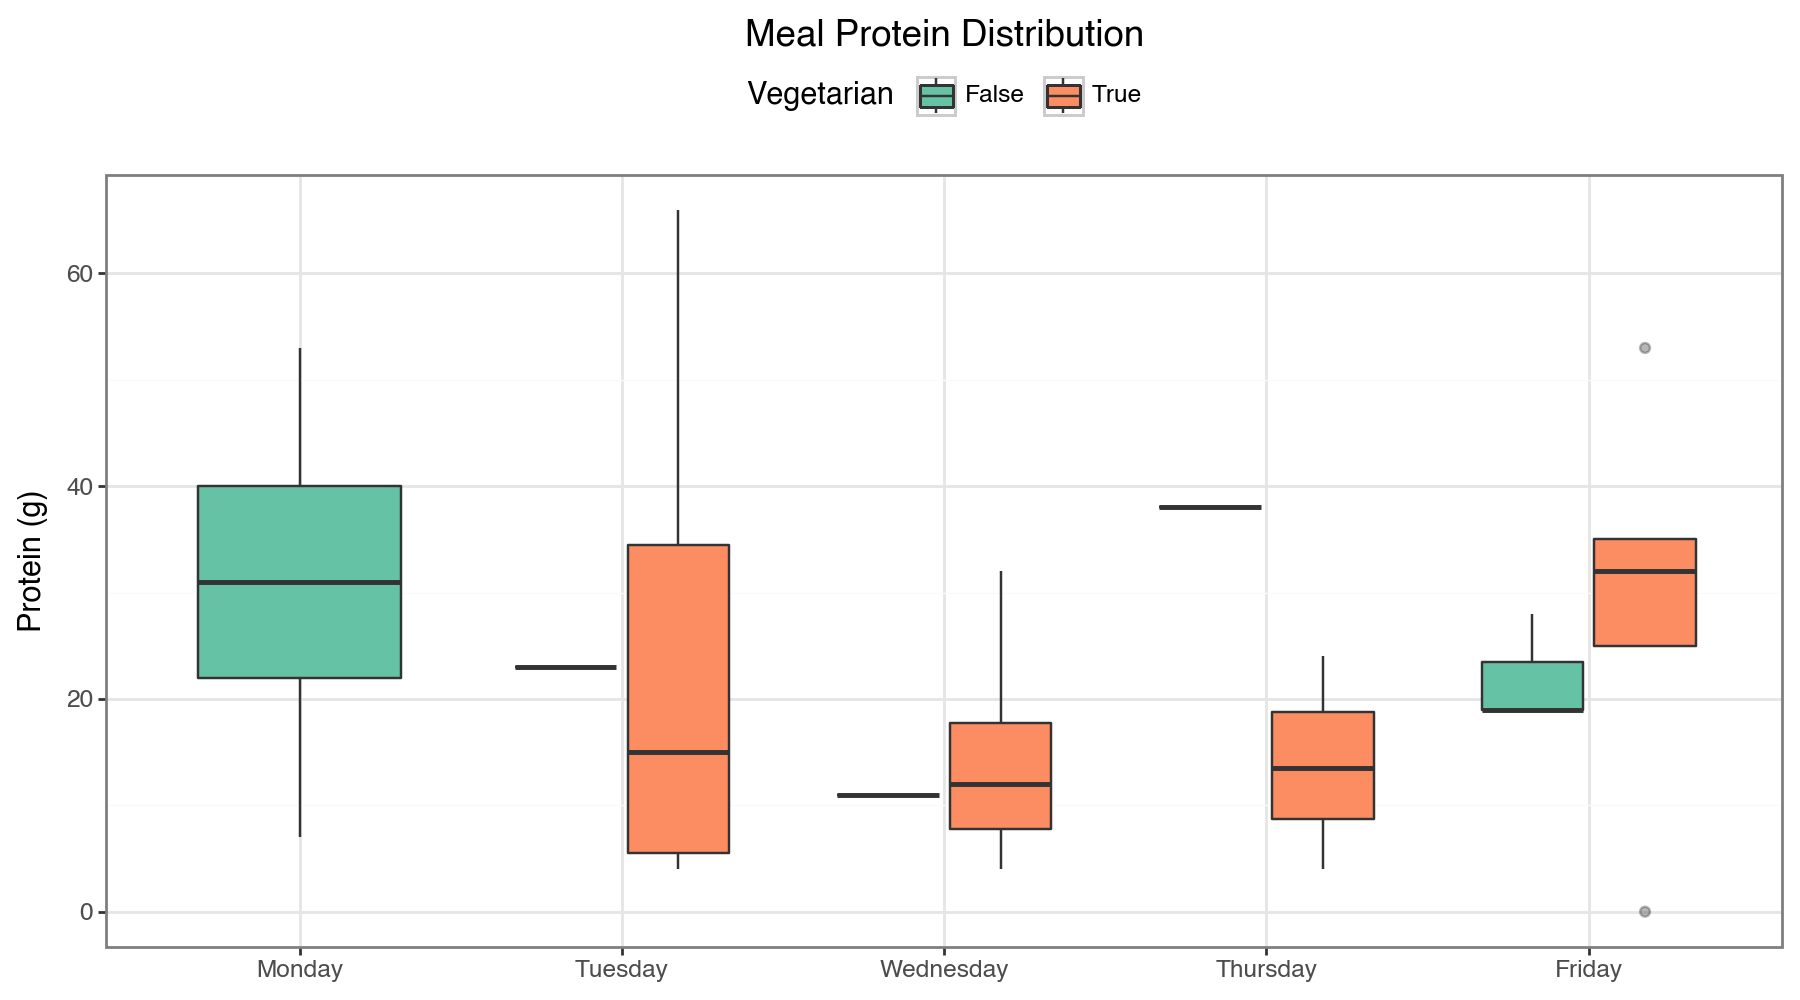

In [20]:
p

Notably there are strong variances in the amount of protein from day to day meaning that this meal plan might not be the best for someone doing a lot of weight training. The graph does show that there is a wide variety of options for the amount of protein for each meal. There are even some days with Vegetarian Options/Alternatives. 